In [1]:
# New pre-processing code to transform the MRI's using FS instead of python
import os
import subprocess
import math
from random import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.interpolate import UnivariateSpline
import SimpleITK as sitk

In [42]:
class mri(object):
    def __init__(self, filename):
        self.conv_file(filename)
        self.ks = np.fft.fftn(self.original)
        self.ks = np.fft.fftshift(self.ks)
        self.max = np.amax(self.original)
        self.min = np.amin(self.original)
        self.ks_vis = np.abs(self.ks)
        self.x, self.y, self.z = self.original.shape
        self.slices = self.x
    
    def conv_file(self, filename):
        reader = sitk.ImageFileReader()
        reader.SetImageIO("NiftiImageIO")
        reader.SetFileName(filename)
        image = reader.Execute()

        # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

        # convert image into np array & perform fft
        img = sitk.GetArrayFromImage(image)
        # Transpose the image so the first axis is Anterior-Posterior
        img = np.transpose(img, (2,1,0))
        self.original = img 
    
    def fft_back(self, kspace):
        # Produce the image given the kspace
        back_fft = np.fft.ifftn(kspace)
        return back_fft

class motion(object):
    # Rotations are taken in as [Roll, Pitch, Yaw]
    def __init__(self, filename, extrap_len=256):
        self.trans_scale = 1
        self.filename = filename
        self.raw = np.loadtxt(filename)
        self.length = len(self.raw)
        self.roll=[]
        self.pitch=[]
        self.yaw = []
        self.trans_x = []
        self.trans_y = []
        self.trans_z = []
        # go through motion file one line at a time
        for i in range(len(self.raw)):
            # Converts the rotations from rads to degrees
            self.roll.append(self.raw[i][0]*180/math.pi)
            self.pitch.append(self.raw[i][1]*180/math.pi)
            self.yaw.append(self.raw[i][2]*180/math.pi)
            # Still need to figure out the conversion of translations from motion file
            self.trans_x.append(self.raw[i][3]*self.trans_scale)
            self.trans_y.append(self.raw[i][4]*self.trans_scale)
            self.trans_z.append(self.raw[i][5]*self.trans_scale)
        #Extrapolate the motion to set length
        old_indices = np.arange(0,self.length)
        new_indices = np.linspace(0,self.length-1, extrap_len)
        
        #extrapolate rotations
        spl = UnivariateSpline(old_indices,self.roll,k=3,s=0)
        self.roll = spl(new_indices)
        spl = UnivariateSpline(old_indices,self.pitch,k=3,s=0)
        self.pitch = spl(new_indices)
        spl = UnivariateSpline(old_indices,self.yaw,k=3,s=0)
        self.yaw = spl(new_indices)
        
        #extrapolate translations
        spl = UnivariateSpline(old_indices,self.trans_x,k=3,s=0)
        self.trans_x = spl(new_indices)
        spl = UnivariateSpline(old_indices,self.trans_y,k=3,s=0)
        self.trans_y = spl(new_indices)
        spl = UnivariateSpline(old_indices,self.trans_z,k=3,s=0)
        self.trans_z = spl(new_indices)
            
def read_file(filename):
    data = np.loadtxt(filename, delimiter=",")
    data = np.reshape(data,(176,256,256))
    return data
def clear_cache(folder):
    for item in os.listdir(folder):
        os.remove(os.path.join(folder, item))

In [30]:
# Convert mris into k-space before rotations
def mri_kspace(folder):
    for item in os.listdir(folder):
        if item.endswith(".nii"):
            mri1 = mri(os.path.join(folder, item))
            
            #saving real part of kspace
            image = sitk.GetImageFromArray(mri1.ks.real)
            sitk.WriteImage(image, folder + '/kspace/' + item[:-4]+'R.nii')
            #saving imag part of kspace
            image = sitk.GetImageFromArray(mri1.ks.imag)
            sitk.WriteImage(image, folder + '/kspace/' + item[:-4]+'I.nii')
mri_kspace('../mris/')

In [31]:
path2motions = os.path.join('../motion/')
path2kspace = os.path.join('../mris/kspace/')

In [32]:
mot1 = motion(os.path.join(path2motions, 'motion1.dat'))

In [39]:
#create the FreeSurfer command to move the volume, should look something like this:#mri_vol2vol --mov starting_volume.nii 
# --o out_volume.nii
# --targ starting_volume.nii 
# --regheader 
# --cubic 
# --rot 0.0677579888523 -0.0097853742957251 0.09004776595637 
# --trans 0.0275581 0.0367374 0.301945
precommand = 'export FREESURFER_HOME=/Applications/freesurfer; source $FREESURFER_HOME/SetUpFreeSurfer.sh; '
wait_rate = 10 # The number of slices that are sent to process at once before waiting for completion
# Creates the caches of rotating the same kspace over motion file
for item in os.listdir(path2kspace):
    if item.endswith("R.nii"):
        for num in range(256):
            rotations = str(mot1.roll[num]) + ' ' + str(mot1.pitch[num]) + ' ' + str(mot1.yaw[num])
            translations = str(mot1.trans_x[num]) + ' ' + str(mot1.trans_y[num]) + ' ' + str(mot1.trans_z[num])
            
            # Create rotated for REAL component
            path2mri = os.path.join(path2kspace, item)
            pathout = os.path.join(path2kspace, 'cache', 'real', str(num) + '.nii')
            # Generate the command to freesurfer
            move_cmd = 'mri_vol2vol --mov ' + path2mri + ' --o ' + pathout + ' --targ ' + path2mri + ' --regheader --cubic --rot ' + rotations + ' --trans ' + translations
            # Send command to bash
            if (num % wait_rate == 0):
                subprocess.Popen(precommand + move_cmd, shell=True).wait()
            else:
                subprocess.Popen(precommand + move_cmd, shell=True)
            
            
            # Create rotated for IMAG component
            item_i = item[:-5]+'I.nii'
            path2mri = os.path.join(path2kspace, item_i)
            pathout = os.path.join(path2kspace, 'cache', 'imag', str(num) + '.nii')
            # Generate the command to freesurfer
            move_cmd = 'mri_vol2vol --mov ' + path2mri + ' --o ' + pathout + ' --targ ' + path2mri + ' --regheader --cubic --rot ' + rotations + ' --trans ' + translations
            # Send command to bash
            subprocess.Popen(precommand + move_cmd, shell=True)
#             subprocess.Popen(precommand + move_cmd, shell=True).wait()
        break # testing only 1 mri

M01R.nii


In [35]:
# Reads in the kspace caches and appends one slice at a time
compiled_img_real = []
compiled_img_imag = []
for i in range(256):
    cache_path = os.path.join(path2kspace, 'cache', 'real', str(i) + '.nii')
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(cache_path)
    image = reader.Execute()
    # convert image into np array & perform fft
    img = sitk.GetArrayFromImage(image)
    compiled_img_real.append(img[i])
    
    cache_path = os.path.join(path2kspace, 'cache', 'imag', str(i) + '.nii')
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(cache_path)
    image = reader.Execute()
    # convert image into np array & perform fft
    img = sitk.GetArrayFromImage(image)
    compiled_img_imag.append(img[i])

In [23]:
compiled_k[0]

array([[     0.         +0.j     ,  -7411.9995  -7411.9995j ,
          4028.352   +4028.352j  , ...,      0.         +0.j     ,
             0.         +0.j     ,      0.         +0.j     ],
       [     0.         +0.j     , -13292.213  -13292.213j  ,
         13080.849  +13080.849j  , ...,      0.         +0.j     ,
             0.         +0.j     ,      0.         +0.j     ],
       [     0.         +0.j     ,   -983.87714  -983.87714j,
          8486.622   +8486.622j  , ...,      0.         +0.j     ,
             0.         +0.j     ,      0.         +0.j     ],
       ...,
       [     0.         +0.j     ,      0.         +0.j     ,
          5358.9746  +5358.9746j , ...,   4269.412   +4269.412j  ,
         23714.79   +23714.79j   , -10328.648  -10328.648j  ],
       [     0.         +0.j     ,      0.         +0.j     ,
          3552.6084  +3552.6084j , ...,   9108.592   +9108.592j  ,
          8477.266   +8477.266j  ,  -8705.363   -8705.363j  ],
       [     0.         +0.j

In [24]:
compiled_img_real[0]

array([[     0.     ,  -7411.9995 ,   4028.352  , ...,      0.     ,
             0.     ,      0.     ],
       [     0.     , -13292.213  ,  13080.849  , ...,      0.     ,
             0.     ,      0.     ],
       [     0.     ,   -983.87714,   8486.622  , ...,      0.     ,
             0.     ,      0.     ],
       ...,
       [     0.     ,      0.     ,   5358.9746 , ...,   4269.412  ,
         23714.79   , -10328.648  ],
       [     0.     ,      0.     ,   3552.6084 , ...,   9108.592  ,
          8477.266  ,  -8705.363  ],
       [     0.     ,      0.     ,   2224.2158 , ...,      0.     ,
             0.     ,      0.     ]], dtype=float32)

In [36]:
compiled_k = compiled_img_real + (np.array(compiled_img_imag)*1j)
compiled_vis = np.fft.ifftn(np.array(compiled_k))

In [41]:
# Saves the transformed mri in visual space
save_path = '../mris/transformed/'
combination = 'M01_Motion01.nii'

image = sitk.GetImageFromArray(np.abs(compiled_vis))
sitk.WriteImage(image, save_path + combination)

In [44]:
# Clears cache of the kspace rotations
clear_cache('../mris/kspace/cache/imag')
clear_cache('../mris/kspace/cache/real')

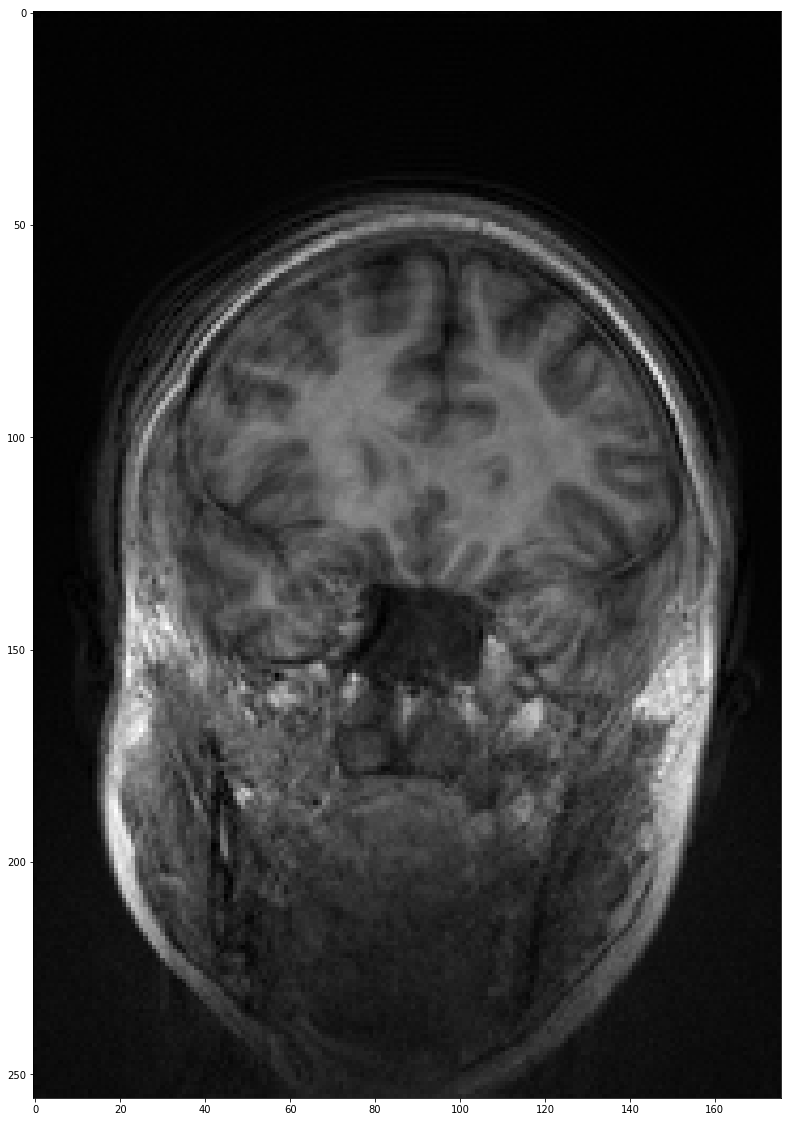

In [38]:
plt.figure(figsize= (20,20))
plt.imshow(np.abs(compiled_vis[100]), cmap='gray')

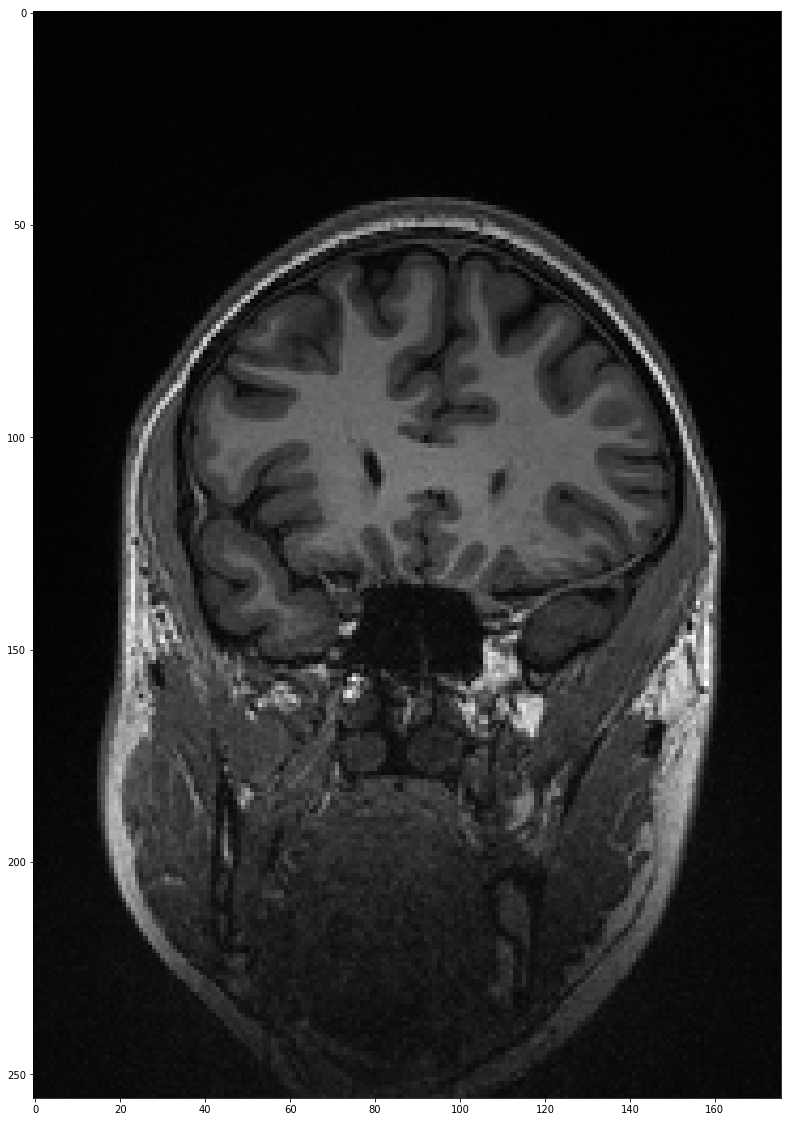

In [140]:
mri1 = mri('../mris/M01.nii')
plt.figure(figsize= (20,20))
plt.imshow(mri1.original[100], cmap='gray')

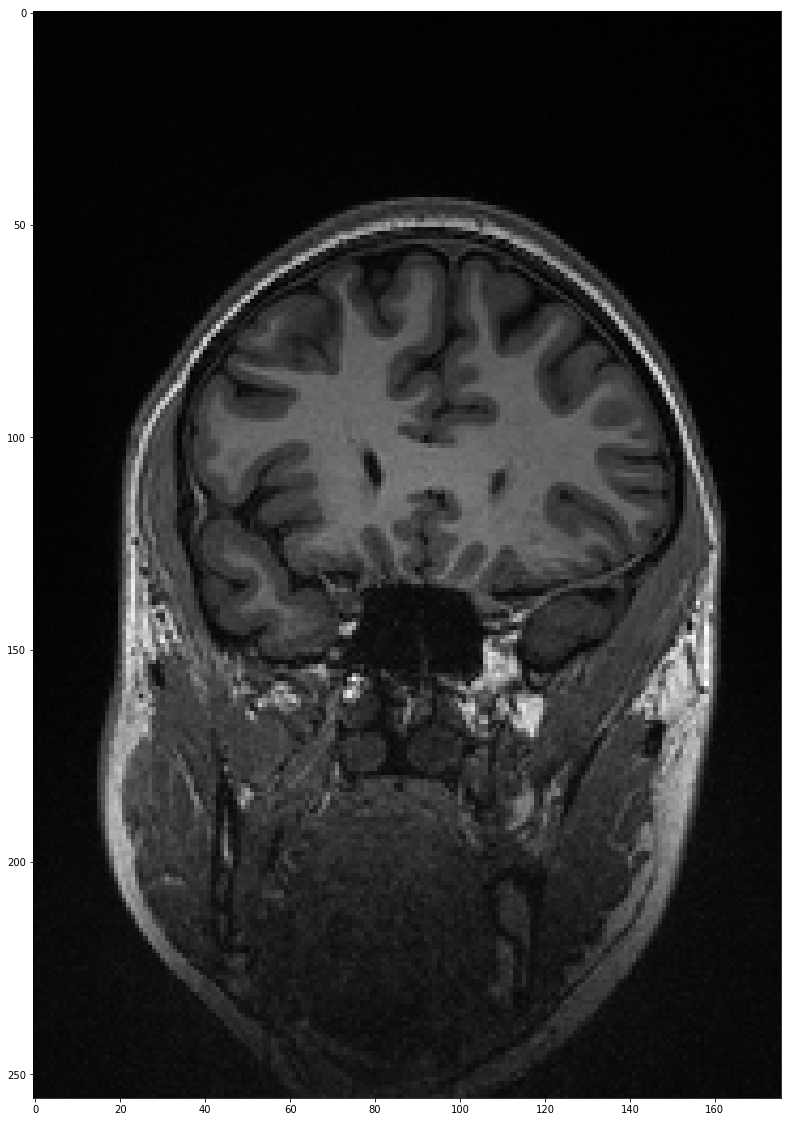

In [144]:
back_vis = np.fft.ifftn(mri1.ks)
plt.figure(figsize= (20,20))
plt.imshow(np.abs(back_vis[100]), cmap='gray')

In [40]:
mot2 = motion(os.path.join(path2motions, 'motion2.dat'))
len(mot2.roll)

244

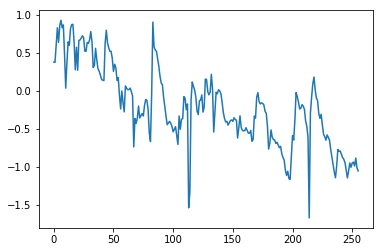

In [44]:
from scipy.interpolate import UnivariateSpline
old_indices = np.arange(0,244)
new_length = 256
new_indices = np.linspace(0,244-1,new_length)
spl = UnivariateSpline(old_indices,mot2.roll,k=3,s=0)
new_array = spl(new_indices)

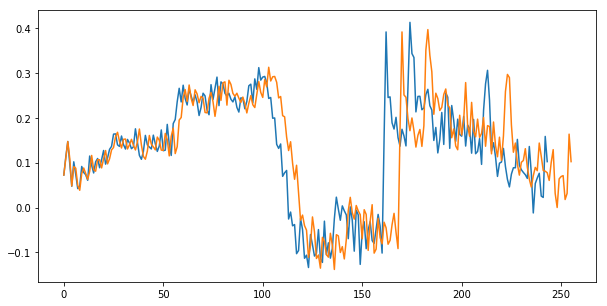

In [49]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(244), mot2.roll)
plt.plot(np.arange(256), new_array)
plt.show()